<a href="https://colab.research.google.com/github/ABR-2005/Secure-quantum-key-distribution-using-the-BB84-protocol/blob/main/BB84_protocol_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
!pip install qiskit


In [13]:
!pip uninstall -y qiskit


Found existing installation: qiskit 1.2.4
Uninstalling qiskit-1.2.4:
  Successfully uninstalled qiskit-1.2.4


In [14]:
!pip install qiskit[all]


  Using cached qiskit-1.2.4-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
Using cached qiskit-1.2.4-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.8 MB)


In [15]:
!pip install qiskit-aer


In [16]:
!pip install qiskit-aer  # Reinstalling qiskit-aer to ensure it's available
from qiskit_aer import Aer  # Importing Aer directly from qiskit_aer
from qiskit import QuantumCircuit
print(Aer.backends())

[AerSimulator('aer_simulator'), AerSimulator('aer_simulator_statevector'), AerSimulator('aer_simulator_density_matrix'), AerSimulator('aer_simulator_stabilizer'), AerSimulator('aer_simulator_matrix_product_state'), AerSimulator('aer_simulator_extended_stabilizer'), AerSimulator('aer_simulator_unitary'), AerSimulator('aer_simulator_superop'), QasmSimulator('qasm_simulator'), StatevectorSimulator('statevector_simulator'), UnitarySimulator('unitary_simulator')]


In [4]:
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile, assemble
from qiskit_aer import Aer  # Import Aer from qiskit_aer instead of qiskit
from qiskit.visualization import plot_histogram, plot_bloch_multivector

WITHOUT INTERCEPTION


     ┌───┐ ░ ┌───┐┌─┐
  q: ┤ H ├─░─┤ H ├┤M├
     └───┘ ░ └───┘└╥┘
c: 1/══════════════╩═
                   0 


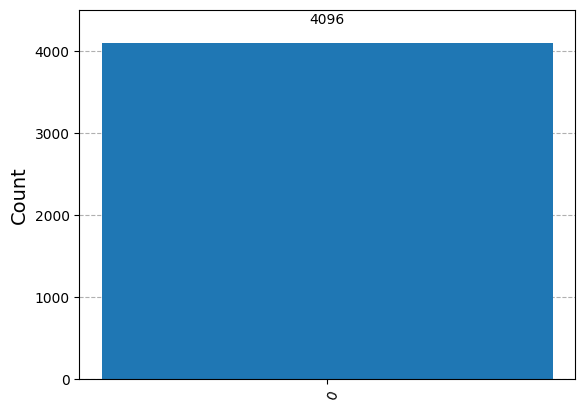

In [10]:
# Step 1: Initialize the Quantum Circuit with 1 qubit and 1 classical bit
qc = QuantumCircuit(1, 1)

# Step 2: Alice prepares the qubit in state |+>
qc.h(0)  # Apply Hadamard gate
qc.barrier()  # Add a barrier to separate preparation and measurement steps

# Step 3: Bob receives the qubit and measures it in the X-basis
qc.h(0)  # Apply Hadamard gate again to switch to X-basis
qc.measure(0, 0)  # Measure the qubit and store the result in classical bit 0

# Step 4: Visualize the circuit
print(qc.draw())  # Display the circuit diagram

# Step 5: Simulate the circuit and get measurement results
aer_simulator = Aer.get_backend('aer_simulator')  # Load the Aer simulator
job = aer_simulator.run(qc, shots=4096)  # Run the simulation with 1024 shots
results = job.result().get_counts()  # Get the counts of measurement results

# Step 6: Plot the results
plot_histogram(results)

WITH INTERCEPTION


     ┌───┐┌─┐ ░ ┌───┐┌─┐
  q: ┤ H ├┤M├─░─┤ H ├┤M├
     └───┘└╥┘ ░ └───┘└╥┘
c: 1/══════╩══════════╩═
           0          0 


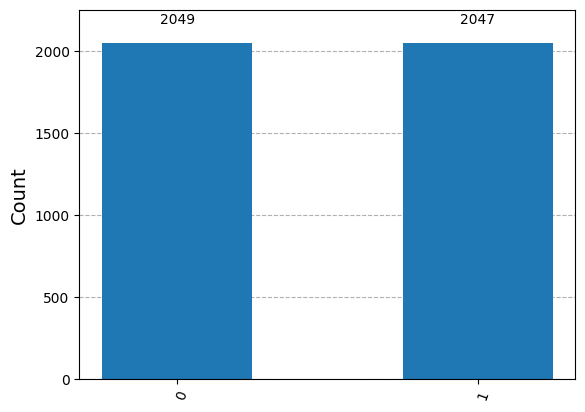

In [17]:
# Step 1: Initialize the Quantum Circuit with 1 qubit and 1 classical bit
qc = QuantumCircuit(1, 1)

# Step 2: Alice prepares the qubit in state |+>
qc.h(0)  # Apply Hadamard gate to create superposition

# Step 3: Eve intercepts the qubit and measures it
qc.measure(0, 0)  # Eve measures the qubit
qc.barrier()  # Add a barrier to separate Eve's interception from Bob's actions

# Step 4: Eve passes the qubit to Bob, who measures it in the X-basis
qc.h(0)  # Bob applies Hadamard gate to switch to X-basis
qc.measure(0, 0)  # Bob measures the qubit

# Step 5: Visualize the circuit
print(qc.draw())  # Display the circuit diagram

# Step 6: Simulate the circuit and get measurement results
aer_simulator = Aer.get_backend('aer_simulator')  # Load the Aer simulator
job = aer_simulator.run(qc, shots=4096)  # Run the simulation with 1024 shots
results = job.result().get_counts()  # Get the counts of measurement results

# Step 7: Plot the results
plot_histogram(results)

COMMUNICATION WITHOUT INTERCEPTION


In [19]:
n = 200
## Step 1
# Alice generates bits.
alice_bits = np.random.randint(0,2,n)

## Step 2
# Create an array to tell us which qubits
# are encoded in which bases
alice_bases = np.random.randint(0,2,n)

# Function to compare the bits & bases generated by alice, and then 'encode' the message. Basically determines the state of the qubit/photon to send.
def encode_message(bits, bases):
    message = []
    for i in range(n):
        qc = QuantumCircuit(1,1)
        if bases[i] == 0: # Prepare qubit in Z-basis
            if bits[i] == 0:
                pass
            else:
                qc.x(0)
        else: # Prepare qubit in X-basis
            if bits[i] == 0:
                qc.h(0)
            else:
                qc.x(0)
                qc.h(0)
        qc.barrier()
        message.append(qc)
    return message

# Alice computes the encoded message using the function defined above.
message = encode_message(alice_bits, alice_bases)

## Step 3

# Decide which basis to measure in:
bob_bases = np.random.randint(0,2,n)

# Function to decode the message sent by alice by comparing qubit/photon states with Bob's generated bases.
def measure_message(message, bases):
    backend = Aer.get_backend('aer_simulator')
    measurements = []
    for q in range(n):
        if bases[q] == 0: # measuring in Z-basis
            message[q].measure(0,0)
        if bases[q] == 1: # measuring in X-basis
            message[q].h(0)
            message[q].measure(0,0)
        # Directly pass the QuantumCircuit to run, not the assembled QasmQobj
        # The change is here
        result = backend.run(message[q], shots=1, memory=True).result()
        measured_bit = int(result.get_memory()[0])
        measurements.append(measured_bit)
    return measurements

# Decode the message according to his bases
bob_results = measure_message(message, bob_bases)

## Step 4

# Function to perform sifting i.e. disregard the bits for which Bob's & A;ice's bases didnot match.
def remove_unmatching_sift_keys(a_bases, b_bases, bits):
    good_bits = []
    for q in range(n):
        if a_bases[q] == b_bases[q]:
            # If both used the same basis, add
            # this to the list of 'good' bits
            good_bits.append(bits[q])
    return good_bits

# Performing sifting for Alice's and Bob's bits.
alice_key = remove_unmatching_sift_keys(alice_bases, bob_bases, alice_bits)
bob_key = remove_unmatching_sift_keys(alice_bases, bob_bases, bob_results)

print("Alice's key after sifting (without interception)", alice_key)
print("Bob's key after sifting (without interception)  ", bob_key)

# # Step 5
# for caluclating the sift bits match
num = 0
for i in range(0,len(bob_key)):
    if alice_key[i] == bob_key[i]:
        num = num + 1

matching_bits = (num/len(bob_key))*100
print(matching_bits,"% of the bits match.")

Alice's key after sifting (without interception) [1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0]
Bob's key after sifting (without interception)   [1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0]
100.0 % of the bits match.


COMMUNICATION WITH INTERCEPTION


In [23]:
## Step 1
alice_bits = np.random.randint(2, size=n)
## Step 2
alice_bases = np.random.randint(2, size=n)
message = encode_message(alice_bits, alice_bases)
## Interception!!
eve_bases = np.random.randint(2, size=n)
intercepted_message = measure_message(message, eve_bases)
## Step 3
bob_bases = np.random.randint(2, size=n)
bob_results = measure_message(message, bob_bases)
## Step 4
bob_key = remove_unmatching_sift_keys(alice_bases, bob_bases, bob_results)
alice_key = remove_unmatching_sift_keys(alice_bases, bob_bases, alice_bits)

print("Alice's key after sifting (with interception)", alice_key)
print("Bob's key after sifting (with interception)  ", bob_key)
# ## Step 5
# Sifted bits won't always match if there is interception
num = 0
for i in range(0,len(bob_key)):
    if alice_key[i] == bob_key[i]:
        num = num + 1

matching_bits = (num/len(bob_key))*100
print(matching_bits,"% of the bits match.")

Alice's key after sifting (with interception) [1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0]
Bob's key after sifting (with interception)   [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0]
62.857142857142854 % of the bits match.


CALCULATION OF PROBABILITY OF EVE DETECTED

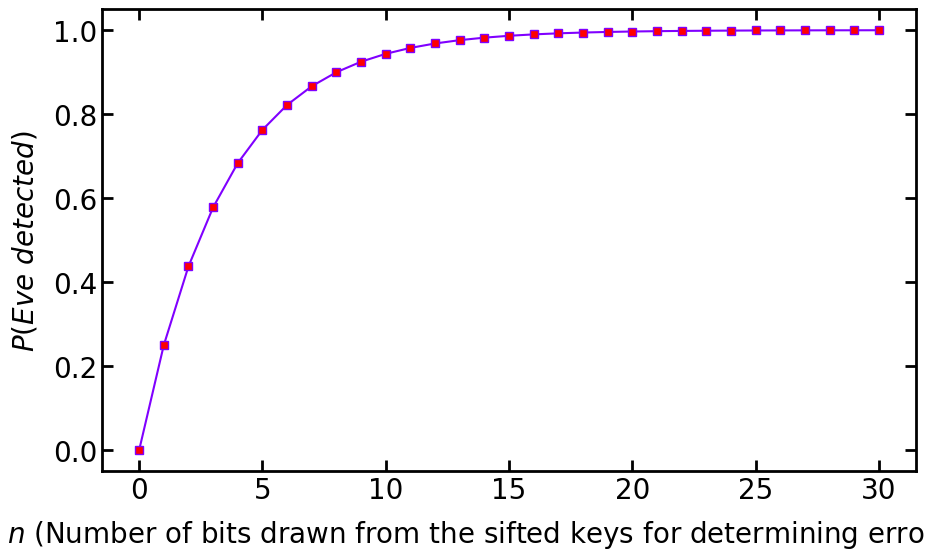

In [27]:

#P(Eve detected) = 1 - P(Eve not detected)
#P(Eve detected) = 1 - (3/4)^n
#lim P(Eve detected)=1
#n->infinity


# Configure plot aesthetics
plt.rcParams['axes.linewidth'] = 2  # Set axis line width
plt.rcParams['font.family'] = ['Georgia']  # Set font family

# Create figure and axis
fig, ax = plt.subplots(figsize=(10.5, 6))  # Define figure size

# Set axis labels and title
ax.set_title('')  # Title (empty for now)
ax.set_xlabel(
    '$n$ (Number of bits drawn from the sifted keys for determining error rate)',
    fontsize=18, labelpad=10
)
ax.set_ylabel(r'$P(Eve\ detected)$', fontsize=18, labelpad=10)

# Configure tick parameters
ax.xaxis.set_tick_params(which='major', size=8, width=2, direction='in', top=True)
ax.yaxis.set_tick_params(which='major', size=8, width=2, direction='in', top=True)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)

# Generate data for the plot
n = 30
x = np.arange(n + 1)  # x-axis values
y = 1 - 0.75**x       # y-axis values (exponential decay function)

# Plot the data
ax.plot(
    x, y,
    color=plt.cm.rainbow(np.linspace(0, 1, 5))[0],  # Gradient color
    marker="s", markerfacecolor='r',  # Square markers with red fill
    label='P(Eve detected)'
)

# Add a legend (if needed in future updates)
# ax.legend(fontsize=15, loc='best')

# Show the plot
plt.show()
